In [1]:
function blackscholes(price, strike, rate, volatility, time)
    logterm   = log10(price / strike)
    powterm   = 0.5f0 * volatility * volatility
    den       = volatility * sqrt(time)
    d1        = (((rate + powterm) * time) + logterm) / den
    d2        = d1 - den
    cndf2d1   = cndf2(d1)
    cndf2d2   = cndf2(d2)
    futureval = strike * exp(-rate * time)
    c1        = futureval * cndf2d2
    call      = price * cndf2d1 - c1
    return call - futureval + price
end
cndf2(x) = 0.5f0 + 0.5f0 * erf(0.707106781f0 * x)

cndf2 (generic function with 1 method)

In [2]:
function benchmark(result, a, b, c, d, e)
    result .= blackscholes.(a, b, c, d, e)
    GPUArrays.synchronize(result)
end

benchmark (generic function with 1 method)

In [4]:
using GPUArrays, SpecialFunctions
N = 10^7
sptprice   = fill(42f0, N)
initStrike = Float32[40 + (i / N) for i = 1:N]
rate       = fill(0.5f0, N)
volatility = fill(0.2f0, N)
time       = fill(0.5f0, N)

result = similar(time)

ctx = CLBackend.init()

sptprice_gpu = GPUArray(sptprice)
initStrike_gpu = GPUArray(initStrike)
rate_gpu = GPUArray(rate)
volatility_gpu = GPUArray(volatility)
time_gpu = GPUArray(time)
result_gpu = GPUArray(result)

ctx

CLContext: Intel(R) HD Graphics Haswell Ultrabook GT2 Mobile

In [5]:
jl = @elapsed benchmark(result, sptprice, initStrike, rate, volatility, time)
cl = @elapsed benchmark(result_gpu, sptprice_gpu, initStrike_gpu, rate_gpu, volatility_gpu, time_gpu)
println(round(jl, 4), "s ", round(cl, 4), "s")
jl / cl

// dependant type declarations
typedef struct {
float empty; // structs can't be empty
}_1blackscholes;

// dependant function declarations
float cndf2_4(float x)
{
    return 0.5 + 0.5 * erf(0.7071067690849304 * x);
}
float broadcast_index_2(__global float * restrict  arg, int shape, int i)
{
    ;
    return arg[i - 1];
    ;
}
float blackscholes_1(float price, float strike, float rate, float volatility, float time)
{
    float call;
    float c1;
    float futureval;
    float cndf2d2;
    float cndf2d1;
    float d2;
    float d1;
    float den;
    float powterm;
    float logterm;
    logterm = log10(price / strike);
    powterm = 0.5 * volatility * volatility;
    den = volatility * sqrt(time);
    d1 = ((rate + powterm) * time + logterm) / den;
    d2 = d1 - den;
    cndf2d1 = cndf2_4(d1);
    cndf2d2 = cndf2_4(d2);
    futureval = strike * exp(-rate * time);
    c1 = futureval * cndf2d2;
    call = price * cndf2d1 - c1;
    return (call - futureval) + price;
}
// Main inner fu

0.34834919867251357

Times in a table:

| Backend | Time in Seconds N = 10^7 | OP/s |
| ---- | ---- |
| OpenCL FirePro W9100 | 0.0014526 | 6.89 e9 |
| CUDA GTX950 | 0.00354474 | 2.8 e9|
| OpenCL GTX950 | 0.0335097 | 3 e8 |
| OpenCL hd4400 | 0.0420179 | 2.3 e8 |
| 8 Threads i7-6700 | 0.199975 | 5 e7 |
| 4 Threads i3-4130 | 0.374679 | 2.7 e7 |
| Julia i7-6700 | 0.937901 |  1.067 e7 |
| Julia i3-4130 | 1.04109 | 9.6 e6 |

In [7]:
using GPUArrays
# julia set
# (the familiar mandelbrot set is obtained by setting c==z initially)
@generated function julia{N}(z, maxiter::Val{N} = Val{16}())
    unrolled = Expr(:block)
    for i=1:N
        push!(unrolled.args, quote
            if abs2(z2) > 4.0
                return $(i-1)
            end
            z2 = z2 * z2 + c
        end)
    end
    quote
        c = Complex64(-0.5, 0.75)
        z2 = z
        $unrolled
        return N
    end
end

julia (generic function with 2 methods)

  0.047870 seconds (46 allocations: 1.891 KiB)
  0.305983 seconds (7 allocations: 256 bytes)


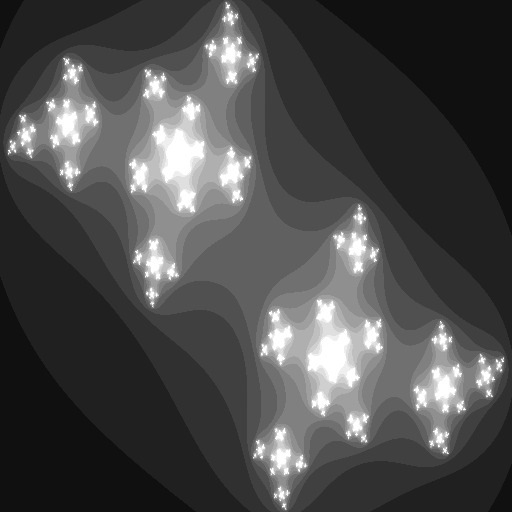

In [9]:
using Colors, Images
w = 2048 * 2;
h = 2048 * 2;
q = [Complex64(r, i) for i=1:-(2.0/w):-1, r=-1.5:(3.0/h):1.5];
m = similar(q, UInt8)

mg = GPUArray(m)
qg = GPUArray(q)
@time (mg .= julia.(qg); GPUArrays.synchronize(mg))
@time (m .= julia.(q))
Gray.(imresize(Array(mg), w ÷ 8, h ÷ 8) ./ 16)